In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim

# Load Boston Housing dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
raw_df = raw_df.dropna()
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]


<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Abdessamad\AppData\Local\Temp\ipykernel_19312\3337661996.py:17: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [2]:
boston_feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]
boston_df = pd.DataFrame(data, columns=boston_feature_names)
boston_df['MEDV'] = target

# Prepare California Housing DataFrame
california = fetch_california_housing()
california_df = pd.DataFrame(california.data, columns=california.feature_names)
california_df['MedHouseVal'] = california.target

# Split into train/test sets
def split_and_scale(df, target_col):
    X = df.drop(target_col, axis=1).values
    y = df[target_col].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

boston_X_train, boston_X_test, boston_y_train, boston_y_test = split_and_scale(boston_df, 'MEDV')
cal_X_train, cal_X_test, cal_y_train, cal_y_test = split_and_scale(california_df, 'MedHouseVal')

In [3]:
# Linear Regression Model (PyTorch)
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.linear(x)

# Neural Network with One Hidden Layer
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [4]:
def to_tensor(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    return X_tensor, y_tensor

# Boston Housing
boston_X_train_t, boston_y_train_t = to_tensor(boston_X_train, boston_y_train)
boston_X_test_t, boston_y_test_t = to_tensor(boston_X_test, boston_y_test)

# California Housing
cal_X_train_t, cal_y_train_t = to_tensor(cal_X_train, cal_y_train)
cal_X_test_t, cal_y_test_t = to_tensor(cal_X_test, cal_y_test)

# Instantiate models
input_dim_boston = boston_X_train.shape[1]
input_dim_cal = cal_X_train.shape[1]

# Linear Regression
boston_lr_model = LinearRegressionModel(input_dim_boston)
cal_lr_model = LinearRegressionModel(input_dim_cal)

# Neural Network
boston_nn_model = SimpleNN(input_dim_boston, hidden_dim=64)
cal_nn_model = SimpleNN(input_dim_cal, hidden_dim=64)

In [167]:
def train_model(model, optimizer_class, X_train, y_train, X_test, y_test, 
                lr=1e-3, epochs=100, momentum=0.9, optimizer_kwargs=None):
    if optimizer_kwargs is None:
        optimizer_kwargs = {}
    criterion = nn.MSELoss()
    # Handle optimizers with/without momentum
    if 'momentum' in optimizer_class.__init__.__code__.co_varnames:
        optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum, **optimizer_kwargs)
    else:
        optimizer = optimizer_class(model.parameters(), lr=lr, **optimizer_kwargs)
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test)
            test_losses.append(test_loss.item())
    return model, train_losses, test_losses

In [168]:
def train_lbfgs(model, X_train, y_train, X_test, y_test, epochs=100, lr=1):
    criterion = nn.MSELoss()
    optimizer = optim.LBFGS(model.parameters(), lr=lr)
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            output = model(X_train)
            loss = criterion(output, y_train)
            loss.backward()
            return loss
        loss = optimizer.step(closure)
        train_losses.append(loss.item())
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test)
            test_losses.append(test_loss.item())
    return model, train_losses, test_losses

# Train with L-BFGS
boston_lr_model_lbfgs = LinearRegressionModel(input_dim_boston)
lbfgs_model, lbfgs_train_losses, lbfgs_test_losses = train_lbfgs(
    boston_lr_model_lbfgs, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t, epochs=50, lr=1
)

# Train with SGD + momentum
boston_lr_model_sgd = LinearRegressionModel(input_dim_boston)
sgd_model, sgd_train_losses, sgd_test_losses = train_model(
    boston_lr_model_sgd, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.01, epochs=50, momentum=0.9
)

# Train with Adam
boston_lr_model_adam = LinearRegressionModel(input_dim_boston)
adam_model, adam_train_losses, adam_test_losses = train_model(
    boston_lr_model_adam, optim.Adam, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.1, epochs=50
)

# boston

## LR

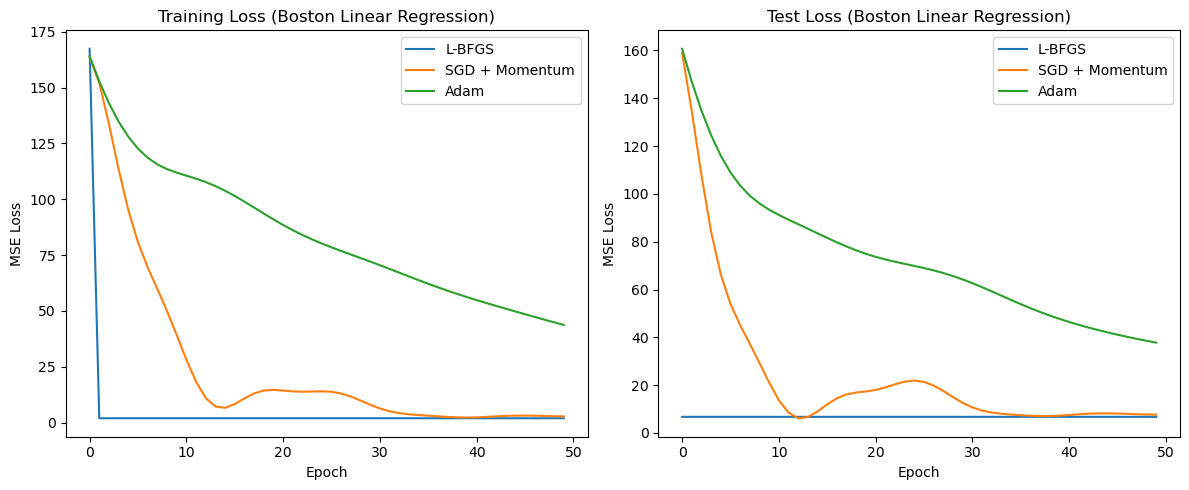

In [13]:
plt.figure(figsize=(12, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(lbfgs_train_losses, label='L-BFGS')
plt.plot(sgd_train_losses, label='SGD + Momentum')
plt.plot(adam_train_losses, label='Adam')
plt.title('Training Loss (Boston Linear Regression)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Test loss
plt.subplot(1, 2, 2)
plt.plot(lbfgs_test_losses, label='L-BFGS')
plt.plot(sgd_test_losses, label='SGD + Momentum')
plt.plot(adam_test_losses, label='Adam')
plt.title('Test Loss (Boston Linear Regression)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
threshold = 20
def first_below(losses, threshold):
    for i, loss in enumerate(losses):
        if loss < threshold:
            return i
    return None

print("Epochs to reach test loss < 20:")
print("L-BFGS:", first_below(lbfgs_test_losses, threshold))
print("SGD + Momentum:", first_below(sgd_test_losses, threshold))
print("Adam:", first_below(adam_test_losses, threshold))

Epochs to reach test loss < 20:
L-BFGS: 0
SGD + Momentum: 10
Adam: None


In [15]:
from sklearn.metrics import r2_score

def get_r2(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        preds = model(X_test).numpy().flatten()
    return r2_score(y_test.numpy().flatten(), preds)

print("R2 Score on Test Set:")
print("L-BFGS:", get_r2(lbfgs_model, boston_X_test_t, boston_y_test_t))
print("SGD + Momentum:", get_r2(sgd_model, boston_X_test_t, boston_y_test_t))
print("Adam:", get_r2(adam_model, boston_X_test_t, boston_y_test_t))

R2 Score on Test Set:
L-BFGS: 0.8503994345664978
SGD + Momentum: 0.8303495645523071
Adam: 0.16205525398254395


In [22]:
learning_rates = [0.001, 0.01, 0.1,0.2,0.3,0.5]
results = {}
for lr in learning_rates:
    model = LinearRegressionModel(input_dim_boston)
    _, _, test_losses = train_model(
        model, optim.Adam, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
        lr=lr, epochs=50
    )
    results[lr] = test_losses[-1]

print("Adam Test Loss for different learning rates:", results)

Adam Test Loss for different learning rates: {0.001: 169.27980041503906, 0.01: 125.81365203857422, 0.1: 40.47332763671875, 0.2: 12.0950288772583, 0.3: 7.421665668487549, 0.5: 8.334263801574707}


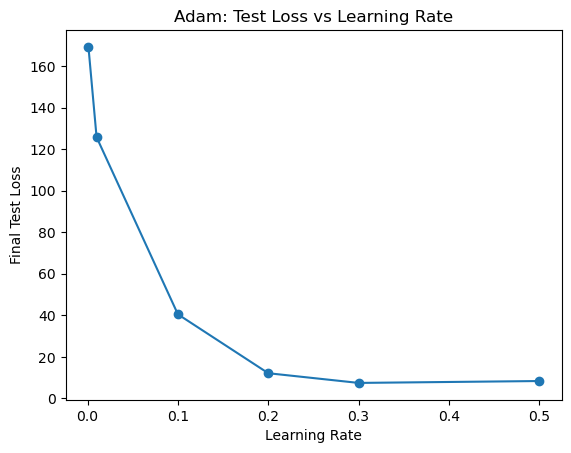

In [23]:


# Prepare for plotting
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('Adam: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

In [32]:
learning_rates = [ 0.1,0.2,0.3,0.5,1]
results = {}
for lr in learning_rates:
    model = LinearRegressionModel(input_dim_boston)
    _, _, test_losses =train_lbfgs(model, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t, epochs=100,lr=lr)
    results[lr] = test_losses[-1]

print("LBFGS Test Loss for different learning rates:", results)

LBFGS Test Loss for different learning rates: {0.1: 6.745009899139404, 0.2: 6.745002269744873, 0.3: 6.745007514953613, 0.5: 6.744901657104492, 1: 6.744940280914307}


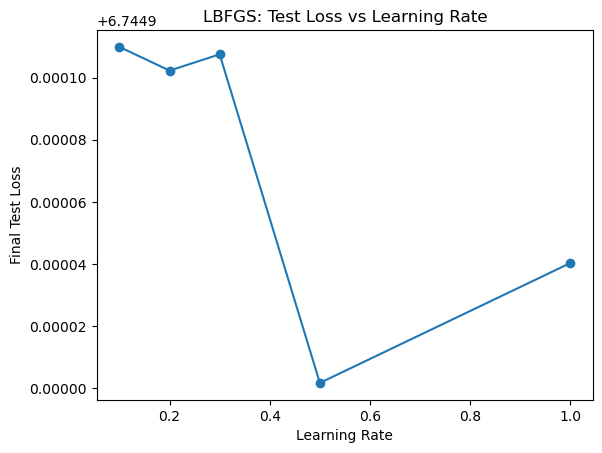

In [33]:

lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('LBFGS: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

In [34]:
learning_rates = [0.001, 0.01, 0.1,0.2,0.3,0.5]
results = {}
for lr in learning_rates:
    model = LinearRegressionModel(input_dim_boston)
    _, _, test_losses = train_model(
        model, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
        lr=lr, epochs=50
    )
    results[lr] = test_losses[-1]

print("SGD Test Loss for different learning rates:", results)

Adam Test Loss for different learning rates: {0.001: 20.89435386657715, 0.01: 7.586531639099121, 0.1: 7.20117712020874, 0.2: 6.794797420501709, 0.3: 13.72474479675293, 0.5: inf}


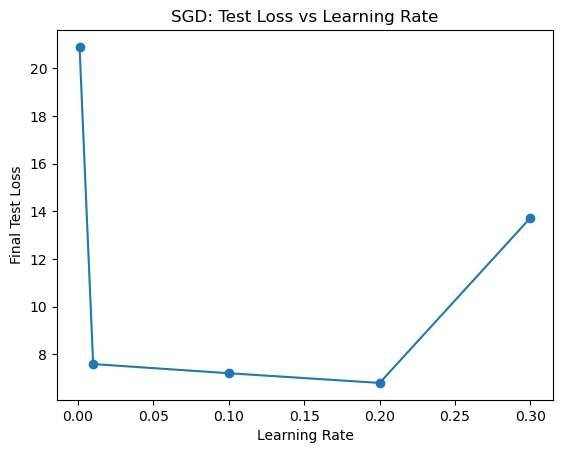

In [35]:
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('SGD: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

In [39]:
momentums = [0.7,0.8,0.9,0.99,1]
results = {}
for mm in momentums:
    model = LinearRegressionModel(input_dim_boston)
    _, _, test_losses = train_model(
        model, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
        lr=0.2, epochs=50,momentum=mm
    )
    results[mm] = test_losses[-1]

print("SGD Test Loss for different momentums:", results)

SGD Test Loss for different momentums: {0.7: 6.745213508605957, 0.8: 6.767336845397949, 0.9: 6.790966033935547, 0.99: 16.807497024536133, 1: 43.9294319152832}


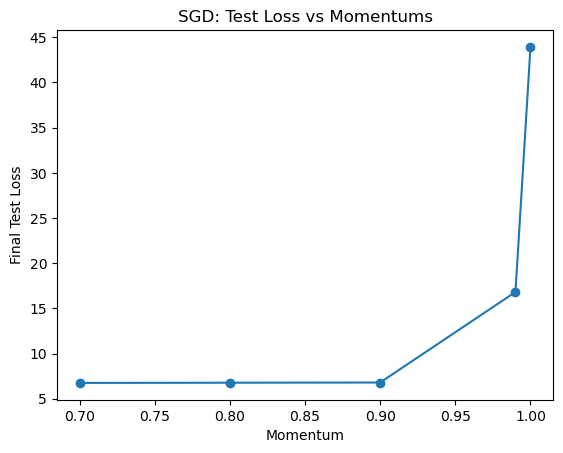

In [40]:
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Momentum')
plt.ylabel('Final Test Loss')
plt.title('SGD: Test Loss vs Momentums')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

In [41]:
import numpy as np
from scipy.optimize import minimize

# Example data (replace with your own)
X = boston_X_train_t.numpy()  # shape (n_samples, n_features)
y = boston_y_train_t.numpy().flatten()  # shape (n_samples,)

def mse_loss(w, X, y):
    preds = X @ w
    return np.mean((preds - y) ** 2)

def mse_grad(w, X, y):
    preds = X @ w
    grad = 2 * X.T @ (preds - y) / len(y)
    return grad

# Initialize weights
w0 = np.zeros(X.shape[1])

result = minimize(
    mse_loss, w0, args=(X, y),
    method='Newton-CG',
    jac=mse_grad,
    options={'maxiter': 100}
)

w_opt = result.x  # optimal weights

# Evaluate on test set
X_test = boston_X_test_t.numpy()
y_test = boston_y_test_t.numpy().flatten()
y_pred = X_test @ w_opt
test_loss = np.mean((y_pred - y_test) ** 2)
print("NewtonCG Test Loss:", test_loss)

NewtonCG Test Loss: 122.80633614467999


In [46]:
def get_param_vector(model):
    return np.concatenate([p.detach().cpu().numpy().ravel() for p in model.parameters()])

# Load parameters from flat numpy vector into model
def set_param_vector(model, vector):
    pointer = 0
    for param in model.parameters():
        num_params = param.numel()
        param.data = torch.from_numpy(
            vector[pointer:pointer+num_params].reshape(param.size())
        ).type(param.data.dtype)
        pointer += num_params

# Loss function and gradient for scipy
def closure(param_vector, model, X, y):
    set_param_vector(model, param_vector)
    model.zero_grad()
    outputs = model(X)
    loss = ((outputs.view(-1) - y) ** 2).mean()
    loss.backward()
    grad = []
    for param in model.parameters():
        grad.append(param.grad.view(-1).cpu().numpy())
    grad = np.concatenate(grad)
    return loss.item(), grad

# Training function
def fit_newtoncg(model, X, y, maxiter=100):
    X = X.detach()
    y = y.detach().view(-1)
    init_params = get_param_vector(model)
    def func(w):
        loss, _ = closure(w, model, X, y)
        return loss
    def grad(w):
        _, g = closure(w, model, X, y)
        return g
    result = minimize(
        func, init_params, jac=grad, method='Newton-CG', options={'maxiter': maxiter}
    )
    set_param_vector(model, result.x)
    return model, result

# Usage example:
# X_train_torch, y_train_torch = ... # your torch tensors
input_dim = boston_X_train_t.shape[1]
model = LinearRegressionModel(input_dim)
model, result = fit_newtoncg(model, boston_X_train_t, boston_y_train_t, maxiter=100)

# Predict and evaluate
with torch.no_grad():
    preds = model(boston_X_train_t).view(-1)
    mse = ((preds - boston_y_train_t) ** 2).mean().item()
print("NewtonCG PyTorch Test Loss:", mse)

NewtonCG PyTorch Test Loss: 170.56491088867188


## nn

In [64]:
boston_nn_model_lbfgs = SimpleNN(input_dim_boston)
lbfgs_model, lbfgs_train_losses, lbfgs_test_losses = train_lbfgs(
    boston_nn_model_lbfgs, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t, epochs=50, lr=1
)

# Train with SGD + momentum
boston_nn_model_sgd = SimpleNN(input_dim_boston)
sgd_model, sgd_train_losses, sgd_test_losses = train_model(
    boston_nn_model_sgd, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.01, epochs=50, momentum=0.9
)

# Train with Adam
boston_nn_model_adam = SimpleNN(input_dim_boston)
adam_model, adam_train_losses, adam_test_losses = train_model(
    boston_nn_model_adam, optim.Adam, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.1, epochs=50
)

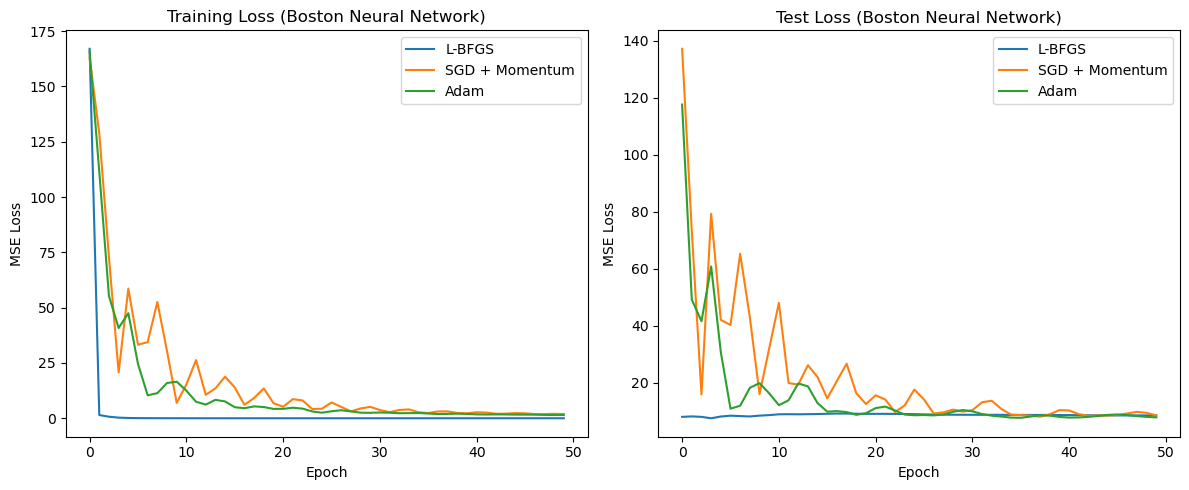

In [65]:
plt.figure(figsize=(12, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(lbfgs_train_losses, label='L-BFGS')
plt.plot(sgd_train_losses, label='SGD + Momentum')
plt.plot(adam_train_losses, label='Adam')
plt.title('Training Loss (Boston Neural Network)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Test loss
plt.subplot(1, 2, 2)
plt.plot(lbfgs_test_losses, label='L-BFGS')
plt.plot(sgd_test_losses, label='SGD + Momentum')
plt.plot(adam_test_losses, label='Adam')
plt.title('Test Loss (Boston Neural Network)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [66]:
threshold = 20
def first_below(losses, threshold):
    for i, loss in enumerate(losses):
        if loss < threshold:
            return i
    return None

print("Epochs to reach test loss < 20:")
print("L-BFGS:", first_below(lbfgs_test_losses, threshold))
print("SGD + Momentum:", first_below(sgd_test_losses, threshold))
print("Adam:", first_below(adam_test_losses, threshold))

Epochs to reach test loss < 20:
L-BFGS: 0
SGD + Momentum: 2
Adam: 5


In [67]:
print("R2 Score on Test Set:")
print("L-BFGS:", get_r2(lbfgs_model, boston_X_test_t, boston_y_test_t))
print("SGD + Momentum:", get_r2(sgd_model, boston_X_test_t, boston_y_test_t))
print("Adam:", get_r2(adam_model, boston_X_test_t, boston_y_test_t))

R2 Score on Test Set:
L-BFGS: 0.8123629093170166
SGD + Momentum: 0.8125902414321899
Adam: 0.8274389505386353


Adam Test Loss for different learning rates: {0.001: 144.09344482421875, 0.01: 7.399421691894531, 0.1: 7.497335433959961, 0.2: 7.714712619781494, 0.3: 8.083528518676758, 0.5: 7.833489894866943}


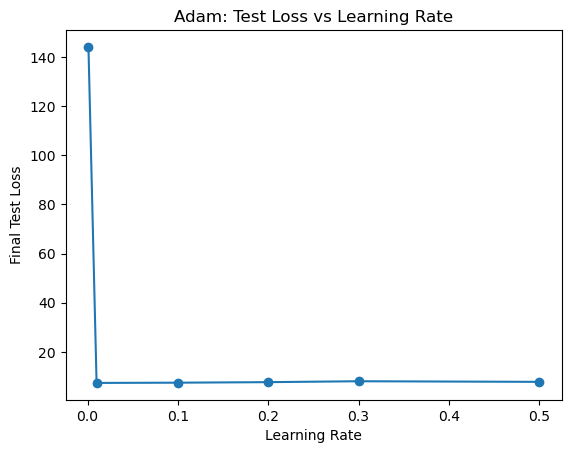

In [68]:

learning_rates = [0.001, 0.01, 0.1,0.2,0.3,0.5]
results = {}
for lr in learning_rates:
    model = SimpleNN(input_dim_boston)
    _, _, test_losses = train_model(
        model, optim.Adam, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
        lr=lr, epochs=50
    )
    results[lr] = test_losses[-1]

print("Adam Test Loss for different learning rates:", results)
# Prepare for plotting
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('Adam: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

LBFGS Test Loss for different learning rates: {0.1: 8.91901683807373, 0.2: 8.899078369140625, 0.3: 7.791234016418457, 0.5: 11.870993614196777, 1: 15.8401460647583}


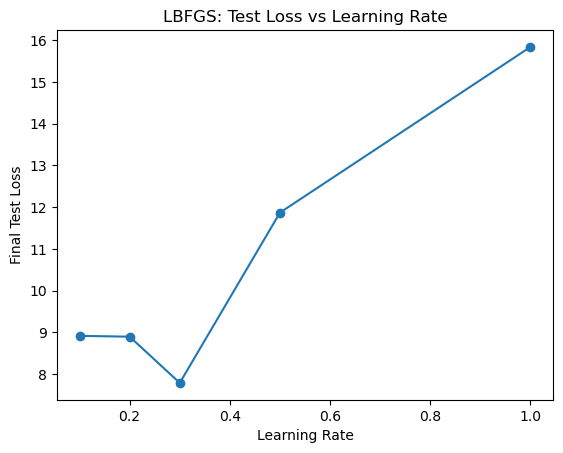

In [69]:
learning_rates = [ 0.1,0.2,0.3,0.5,1]
results = {}
for lr in learning_rates:
    model = SimpleNN(input_dim_boston)
    _, _, test_losses =train_lbfgs(model, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t, epochs=100,lr=lr)
    results[lr] = test_losses[-1]

print("LBFGS Test Loss for different learning rates:", results)
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('LBFGS: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

SGD Test Loss for different learning rates: {0.001: 8.598258972167969, 0.01: 8.07027816772461, 0.1: nan}


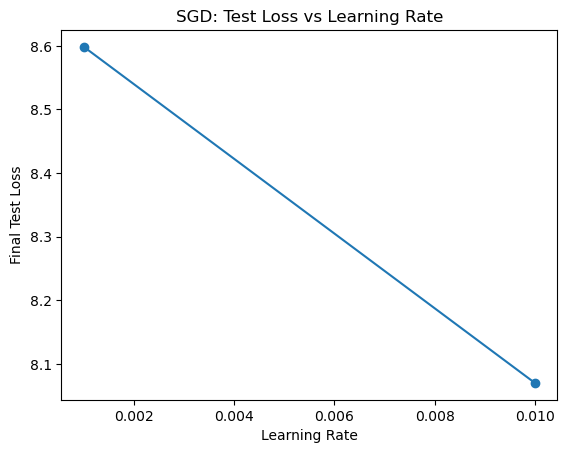

In [75]:
learning_rates = [0.001, 0.01, 0.1]
results = {}
for lr in learning_rates:
    model = SimpleNN(input_dim_boston)
    _, _, test_losses = train_model(
        model, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
        lr=lr, epochs=50
    )
    results[lr] = test_losses[-1]

print("SGD Test Loss for different learning rates:", results)
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('SGD: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

In [71]:
results

{0.001: 9.034839630126953, 0.01: 7.879741191864014, 0.1: nan}

SGD Test Loss for different momentums: {0.7: 7.941098690032959, 0.8: 8.101673126220703, 0.9: 8.122713088989258, 0.99: 7.70363712310791, 1: 13.161272048950195}


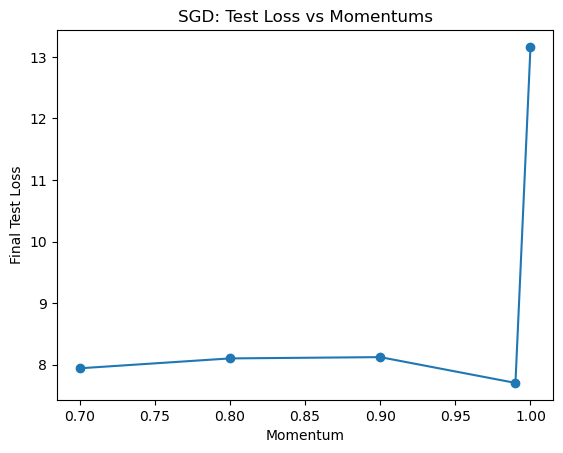

In [72]:
momentums = [0.7,0.8,0.9,0.99,1]
results = {}
for mm in momentums:
    model = SimpleNN(input_dim_boston)
    _, _, test_losses = train_model(
        model, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
        lr=0.01, epochs=50,momentum=mm
    )
    results[mm] = test_losses[-1]

print("SGD Test Loss for different momentums:", results)
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Momentum')
plt.ylabel('Final Test Loss')
plt.title('SGD: Test Loss vs Momentums')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

In [73]:
def get_param_vector(model):
    return np.concatenate([p.detach().cpu().numpy().ravel() for p in model.parameters()])

# Load parameters from flat numpy vector into model
def set_param_vector(model, vector):
    pointer = 0
    for param in model.parameters():
        num_params = param.numel()
        param.data = torch.from_numpy(
            vector[pointer:pointer+num_params].reshape(param.size())
        ).type(param.data.dtype)
        pointer += num_params

# Loss function and gradient for scipy
def closure(param_vector, model, X, y):
    set_param_vector(model, param_vector)
    model.zero_grad()
    outputs = model(X)
    loss = ((outputs.view(-1) - y) ** 2).mean()
    loss.backward()
    grad = []
    for param in model.parameters():
        grad.append(param.grad.view(-1).cpu().numpy())
    grad = np.concatenate(grad)
    return loss.item(), grad

# Training function
def fit_newtoncg(model, X, y, maxiter=100):
    X = X.detach()
    y = y.detach().view(-1)
    init_params = get_param_vector(model)
    def func(w):
        loss, _ = closure(w, model, X, y)
        return loss
    def grad(w):
        _, g = closure(w, model, X, y)
        return g
    result = minimize(
        func, init_params, jac=grad, method='Newton-CG', options={'maxiter': maxiter}
    )
    set_param_vector(model, result.x)
    return model, result

# Usage example:
# X_train_torch, y_train_torch = ... # your torch tensors
input_dim = boston_X_train_t.shape[1]
model = SimpleNN(input_dim)
model, result = fit_newtoncg(model, boston_X_train_t, boston_y_train_t, maxiter=100)

# Predict and evaluate
with torch.no_grad():
    preds = model(boston_X_train_t).view(-1)
    mse = ((preds - boston_y_train_t) ** 2).mean().item()
print("NewtonCG PyTorch Test Loss:", mse)

NewtonCG PyTorch Test Loss: 88.30899810791016


In [74]:
get_r2(model, boston_X_test_t, boston_y_test_t)

0.8224563598632812

# California


## nn

In [95]:
cal_nn_model_lbfgs = SimpleNN(input_dim_cal)
lbfgs_model, lbfgs_train_losses, lbfgs_test_losses = train_lbfgs(
    cal_nn_model_lbfgs, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t, epochs=50, lr=1
)

# Train with SGD + momentum
cal_nn_model_sgd = SimpleNN(input_dim_cal)
sgd_model, sgd_train_losses, sgd_test_losses = train_model(
    cal_nn_model_sgd, optim.SGD, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.01, epochs=50, momentum=0.9
)

# Train with Adam
cal_nn_model_adam = SimpleNN(input_dim_cal)
adam_model, adam_train_losses, adam_test_losses = train_model(
    cal_nn_model_adam, optim.Adam, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.1, epochs=50
)

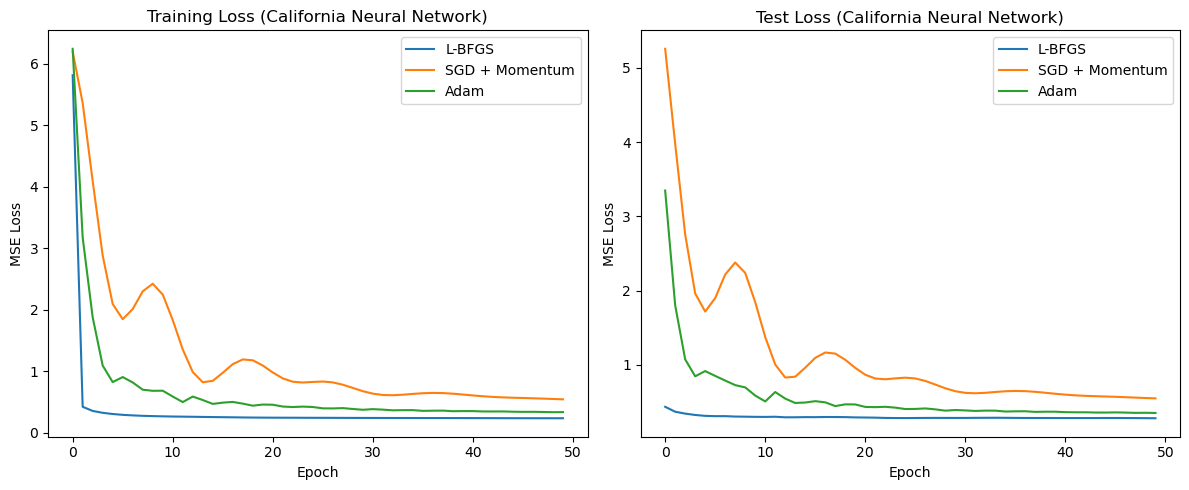

In [96]:
plt.figure(figsize=(12, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(lbfgs_train_losses, label='L-BFGS')
plt.plot(sgd_train_losses, label='SGD + Momentum')
plt.plot(adam_train_losses, label='Adam')
plt.title('Training Loss (California Neural Network)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Test loss
plt.subplot(1, 2, 2)
plt.plot(lbfgs_test_losses, label='L-BFGS')
plt.plot(sgd_test_losses, label='SGD + Momentum')
plt.plot(adam_test_losses, label='Adam')
plt.title('Test Loss (California Neural Network)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [97]:
threshold = 20
def first_below(losses, threshold):
    for i, loss in enumerate(losses):
        if loss < threshold:
            return i
    return None

print("Epochs to reach test loss < 20:")
print("L-BFGS:", first_below(lbfgs_test_losses, threshold))
print("SGD + Momentum:", first_below(sgd_test_losses, threshold))
print("Adam:", first_below(adam_test_losses, threshold))

Epochs to reach test loss < 20:
L-BFGS: 0
SGD + Momentum: 0
Adam: 0


In [98]:
from sklearn.metrics import r2_score

def get_r2(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        preds = model(X_test).numpy().flatten()
    return r2_score(y_test.numpy().flatten(), preds)

print("R2 Score on Test Set:")
print("L-BFGS:", get_r2(lbfgs_model, cal_X_test_t, cal_y_test_t))
print("SGD + Momentum:", get_r2(sgd_model, cal_X_test_t, cal_y_test_t))
print("Adam:", get_r2(adam_model, cal_X_test_t, cal_y_test_t))

R2 Score on Test Set:
L-BFGS: 0.7854635715484619
SGD + Momentum: 0.5810403227806091
Adam: 0.730953574180603


Adam Test Loss for different learning rates: {0.001: 2.8318986892700195, 0.01: 0.5535943508148193, 0.1: 0.35337889194488525, 0.2: 0.3723129332065582, 0.3: 0.5487932562828064, 0.5: 1.1260476112365723}


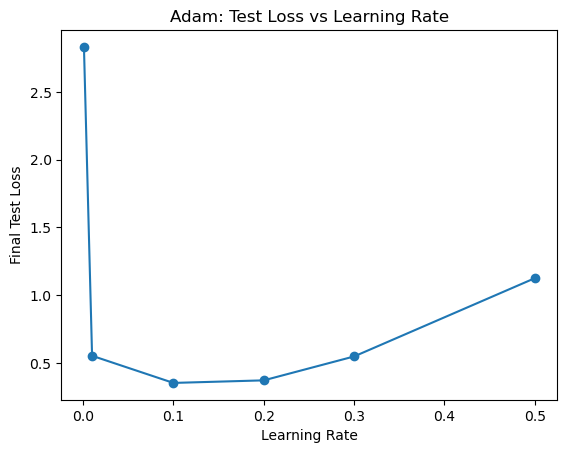

In [101]:

learning_rates = [0.001, 0.01, 0.1,0.2,0.3,0.5]
results = {}
for lr in learning_rates:
    model = SimpleNN(input_dim_cal)
    _, _, test_losses = train_model(
        model, optim.Adam, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
        lr=lr, epochs=50
    )
    results[lr] = test_losses[-1]

print("Adam Test Loss for different learning rates:", results)
# Prepare for plotting
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('Adam: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

LBFGS Test Loss for different learning rates: {0.1: 0.28514188528060913, 0.2: 0.2762879431247711, 0.3: 0.275393545627594, 0.5: 0.2966926097869873, 1: 0.27951377630233765}


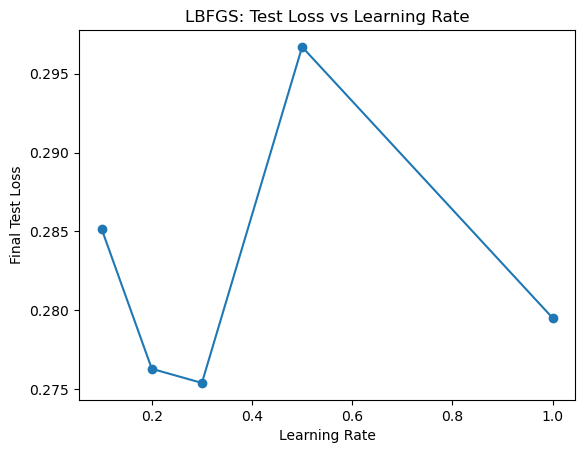

In [102]:
learning_rates = [ 0.1,0.2,0.3,0.5,1]
results = {}
for lr in learning_rates:
    model = SimpleNN(input_dim_cal)
    _, _, test_losses =train_lbfgs(model, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t, epochs=100,lr=lr)
    results[lr] = test_losses[-1]

print("LBFGS Test Loss for different learning rates:", results)
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('LBFGS: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

Adam Test Loss for different learning rates: {0.001: 0.7804681658744812, 0.01: 0.5358361601829529, 0.1: 0.43552979826927185, 0.2: 0.3898077607154846, 0.3: 0.5554698705673218, 0.5: nan}


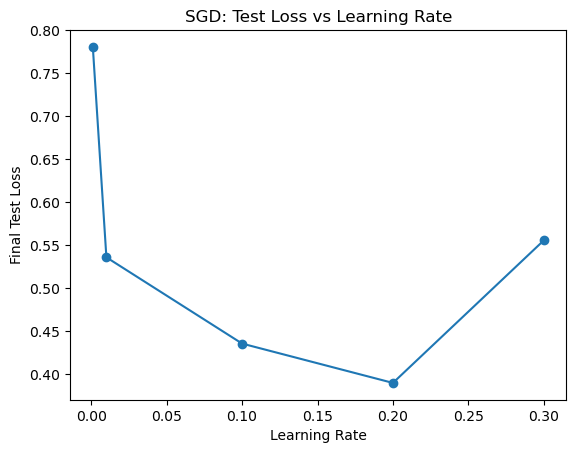

In [104]:
learning_rates = [0.001, 0.01, 0.1,0.2,0.3,0.5]
results = {}
for lr in learning_rates:
    model = SimpleNN(input_dim_cal)
    _, _, test_losses = train_model(
        model, optim.SGD, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
        lr=lr, epochs=50
    )
    results[lr] = test_losses[-1]

print("SGD Test Loss for different learning rates:", results)

lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('SGD: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

SGD Test Loss for different momentums: {0.7: 0.5564243793487549, 0.8: 0.5559769868850708, 0.9: 0.5609018206596375, 0.99: 1.3750672340393066, 1: 2.117324113845825}


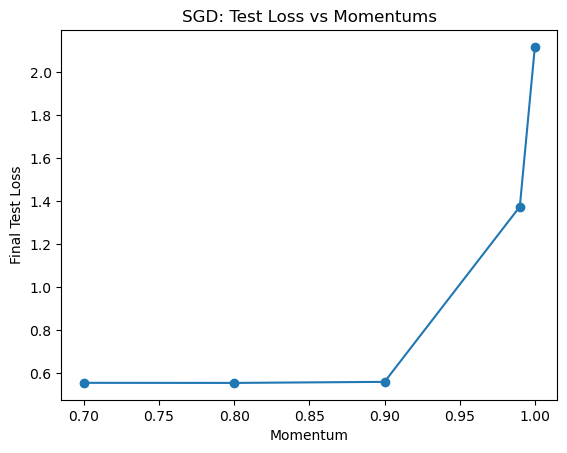

In [105]:
momentums = [0.7,0.8,0.9,0.99,1]
results = {}
for mm in momentums:
    model = LinearRegressionModel(input_dim_cal)
    _, _, test_losses = train_model(
        model, optim.SGD, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
        lr=0.2, epochs=50,momentum=mm
    )
    results[mm] = test_losses[-1]

print("SGD Test Loss for different momentums:", results)
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Momentum')
plt.ylabel('Final Test Loss')
plt.title('SGD: Test Loss vs Momentums')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import minimize

# Example data (replace with your own)
X = cal_X_train_t.numpy()  # shape (n_samples, n_features)
y = cal_y_train_t.numpy().flatten()  # shape (n_samples,)

def mse_loss(w, X, y):
    preds = X @ w
    return np.mean((preds - y) ** 2)

def mse_grad(w, X, y):
    preds = X @ w
    grad = 2 * X.T @ (preds - y) / len(y)
    return grad

# Initialize weights
w0 = np.zeros(X.shape[1])

result = minimize(
    mse_loss, w0, args=(X, y),
    method='Newton-CG',
    jac=mse_grad,
    options={'maxiter': 100}
)

w_opt = result.x  # optimal weights

# Evaluate on test set
X_test = cal_X_test_t.numpy()
y_test = cal_y_test_t.numpy().flatten()
y_pred = X_test @ w_opt
test_loss = np.mean((y_pred - y_test) ** 2)
print("NewtonCG Test Loss:", test_loss)

In [106]:
def get_param_vector(model):
    return np.concatenate([p.detach().cpu().numpy().ravel() for p in model.parameters()])

# Load parameters from flat numpy vector into model
def set_param_vector(model, vector):
    pointer = 0
    for param in model.parameters():
        num_params = param.numel()
        param.data = torch.from_numpy(
            vector[pointer:pointer+num_params].reshape(param.size())
        ).type(param.data.dtype)
        pointer += num_params

# Loss function and gradient for scipy
def closure(param_vector, model, X, y):
    set_param_vector(model, param_vector)
    model.zero_grad()
    outputs = model(X)
    loss = ((outputs.view(-1) - y) ** 2).mean()
    loss.backward()
    grad = []
    for param in model.parameters():
        grad.append(param.grad.view(-1).cpu().numpy())
    grad = np.concatenate(grad)
    return loss.item(), grad

# Training function
def fit_newtoncg(model, X, y, maxiter=100):
    X = X.detach()
    y = y.detach().view(-1)
    init_params = get_param_vector(model)
    def func(w):
        loss, _ = closure(w, model, X, y)
        return loss
    def grad(w):
        _, g = closure(w, model, X, y)
        return g
    result = minimize(
        func, init_params, jac=grad, method='Newton-CG', options={'maxiter': maxiter}
    )
    set_param_vector(model, result.x)
    return model, result

# Usage example:
# X_train_torch, y_train_torch = ... # your torch tensors
input_dim = cal_X_train_t.shape[1]
model = SimpleNN(input_dim)
model, result = fit_newtoncg(model, cal_X_train_t, cal_y_train_t, maxiter=100)

# Predict and evaluate
with torch.no_grad():
    preds = model(cal_X_train_t).view(-1)
    mse = ((preds - cal_y_train_t) ** 2).mean().item()
print("NewtonCG PyTorch Test Loss:", mse)

NewtonCG PyTorch Test Loss: 2.148618698120117


In [107]:
get_r2(model, cal_X_test_t, cal_y_test_t)

0.5892729759216309

## LR

In [79]:
cal_lr_model_lbfgs = LinearRegressionModel(input_dim_cal)
lbfgs_model, lbfgs_train_losses, lbfgs_test_losses = train_lbfgs(
    cal_lr_model_lbfgs, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t, epochs=50, lr=1
)

# Train with SGD + momentum
cal_lr_model_sgd = LinearRegressionModel(input_dim_cal)
sgd_model, sgd_train_losses, sgd_test_losses = train_model(
    cal_lr_model_sgd, optim.SGD, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.01, epochs=50, momentum=0.9
)

# Train with Adam
cal_lr_model_adam = LinearRegressionModel(input_dim_cal)
adam_model, adam_train_losses, adam_test_losses = train_model(
    cal_lr_model_adam, optim.Adam, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.1, epochs=50
)

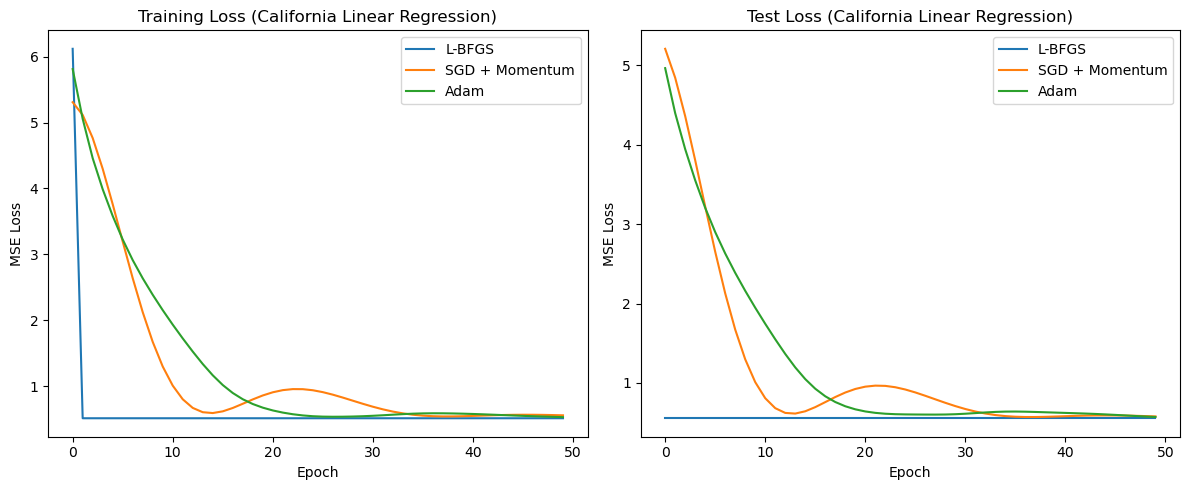

In [81]:
plt.figure(figsize=(12, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(lbfgs_train_losses, label='L-BFGS')
plt.plot(sgd_train_losses, label='SGD + Momentum')
plt.plot(adam_train_losses, label='Adam')
plt.title('Training Loss (California Linear Regression)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Test loss
plt.subplot(1, 2, 2)
plt.plot(lbfgs_test_losses, label='L-BFGS')
plt.plot(sgd_test_losses, label='SGD + Momentum')
plt.plot(adam_test_losses, label='Adam')
plt.title('Test Loss (California Linear Regression)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [82]:
threshold = 20
def first_below(losses, threshold):
    for i, loss in enumerate(losses):
        if loss < threshold:
            return i
    return None

print("Epochs to reach test loss < 20:")
print("L-BFGS:", first_below(lbfgs_test_losses, threshold))
print("SGD + Momentum:", first_below(sgd_test_losses, threshold))
print("Adam:", first_below(adam_test_losses, threshold))

Epochs to reach test loss < 20:
L-BFGS: 0
SGD + Momentum: 0
Adam: 0


In [94]:
from sklearn.metrics import r2_score

def get_r2(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        preds = model(X_test).numpy().flatten()
    return r2_score(y_test.numpy().flatten(), preds)

print("R2 Score on Test Set:")
print("L-BFGS:", get_r2(lbfgs_model, cal_X_test_t, cal_y_test_t))
print("SGD + Momentum:", get_r2(sgd_model, cal_X_test_t, cal_y_test_t))
print("Adam:", get_r2(adam_model, cal_X_test_t, cal_y_test_t))

R2 Score on Test Set:
L-BFGS: 0.5757879018783569
SGD + Momentum: 0.5581884980201721
Adam: 0.5636129379272461


In [84]:
learning_rates = [0.001, 0.01, 0.1,0.2,0.3,0.5]
results = {}
for lr in learning_rates:
    model = LinearRegressionModel(input_dim_boston)
    _, _, test_losses = train_model(
        model, optim.Adam, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
        lr=lr, epochs=50
    )
    results[lr] = test_losses[-1]

print("Adam Test Loss for different learning rates:", results)

Adam Test Loss for different learning rates: {0.001: 174.19808959960938, 0.01: 111.82193756103516, 0.1: 39.423709869384766, 0.2: 11.764924049377441, 0.3: 7.174442768096924, 0.5: 8.05521297454834}


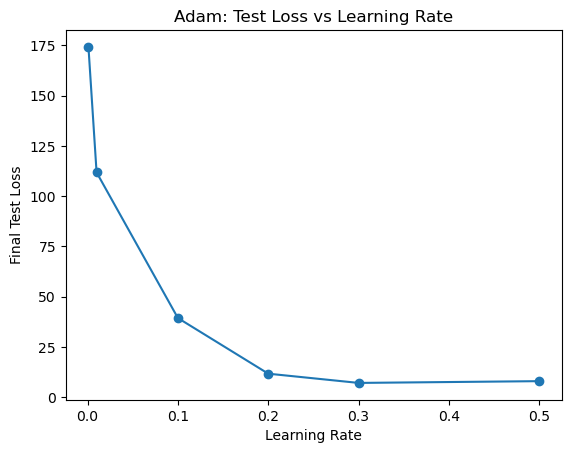

In [85]:


# Prepare for plotting
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('Adam: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

In [86]:
learning_rates = [ 0.1,0.2,0.3,0.5,1]
results = {}
for lr in learning_rates:
    model = LinearRegressionModel(input_dim_boston)
    _, _, test_losses =train_lbfgs(model, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t, epochs=100,lr=lr)
    results[lr] = test_losses[-1]

print("LBFGS Test Loss for different learning rates:", results)

LBFGS Test Loss for different learning rates: {0.1: 6.744995594024658, 0.2: 6.745003700256348, 0.3: 6.744986057281494, 0.5: 6.744957447052002, 1: 6.74495267868042}


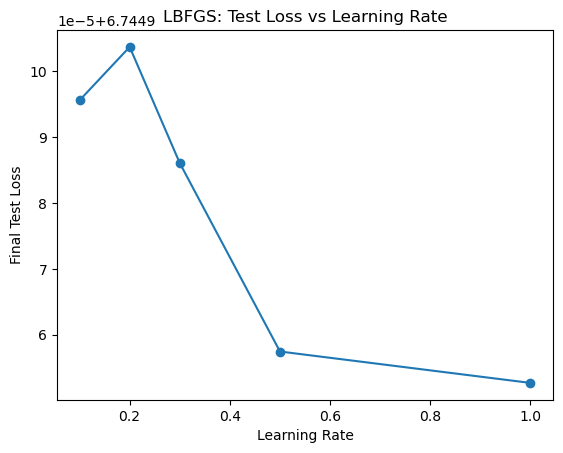

In [87]:

lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('LBFGS: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

In [88]:
learning_rates = [0.001, 0.01, 0.1,0.2,0.3,0.5]
results = {}
for lr in learning_rates:
    model = LinearRegressionModel(input_dim_boston)
    _, _, test_losses = train_model(
        model, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
        lr=lr, epochs=50
    )
    results[lr] = test_losses[-1]

print("Adam Test Loss for different learning rates:", results)

Adam Test Loss for different learning rates: {0.001: 21.736907958984375, 0.01: 7.676685810089111, 0.1: 7.183502674102783, 0.2: 6.799330234527588, 0.3: 12.167976379394531, 0.5: inf}


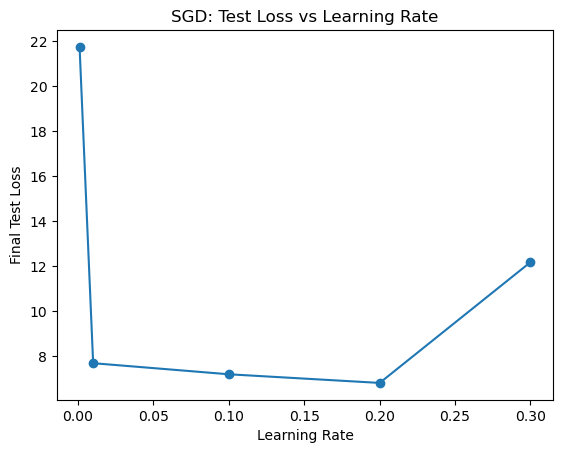

In [89]:

lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.title('SGD: Test Loss vs Learning Rate')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

In [90]:
momentums = [0.7,0.8,0.9,0.99,1]
results = {}
for mm in momentums:
    model = LinearRegressionModel(input_dim_boston)
    _, _, test_losses = train_model(
        model, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
        lr=0.2, epochs=50,momentum=mm
    )
    results[mm] = test_losses[-1]

print("SGD Test Loss for different momentums:", results)

SGD Test Loss for different momentums: {0.7: 6.745363235473633, 0.8: 6.767757415771484, 0.9: 6.792654514312744, 0.99: 17.505537033081055, 1: 40.432647705078125}


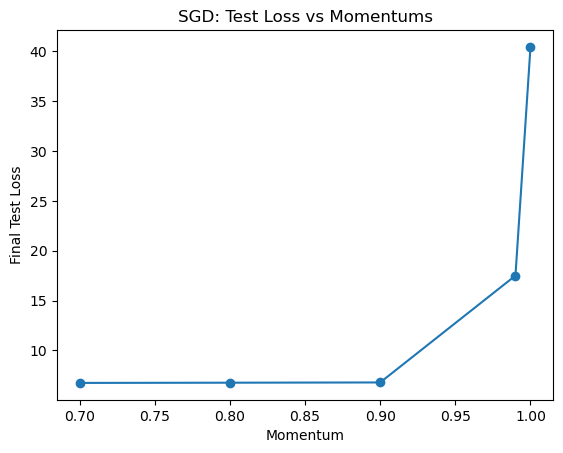

In [91]:
lrs = list(results.keys())
final_losses = list(results.values())

plt.plot(lrs, final_losses, marker='o')
plt.xlabel('Momentum')
plt.ylabel('Final Test Loss')
plt.title('SGD: Test Loss vs Momentums')
# plt.xscale('log')  # Optional: log scale makes sense for learning rates
plt.show()

In [92]:
import numpy as np
from scipy.optimize import minimize

# Example data (replace with your own)
X = boston_X_train_t.numpy()  # shape (n_samples, n_features)
y = boston_y_train_t.numpy().flatten()  # shape (n_samples,)

def mse_loss(w, X, y):
    preds = X @ w
    return np.mean((preds - y) ** 2)

def mse_grad(w, X, y):
    preds = X @ w
    grad = 2 * X.T @ (preds - y) / len(y)
    return grad

# Initialize weights
w0 = np.zeros(X.shape[1])

result = minimize(
    mse_loss, w0, args=(X, y),
    method='Newton-CG',
    jac=mse_grad,
    options={'maxiter': 100}
)

w_opt = result.x  # optimal weights

# Evaluate on test set
X_test = boston_X_test_t.numpy()
y_test = boston_y_test_t.numpy().flatten()
y_pred = X_test @ w_opt
test_loss = np.mean((y_pred - y_test) ** 2)
print("NewtonCG Test Loss:", test_loss)

NewtonCG Test Loss: 122.80633614467999


In [130]:
def get_param_vector(model):
    return np.concatenate([p.detach().cpu().numpy().ravel() for p in model.parameters()])

# Load parameters from flat numpy vector into model
def set_param_vector(model, vector):
    pointer = 0
    for param in model.parameters():
        num_params = param.numel()
        param.data = torch.from_numpy(
            vector[pointer:pointer+num_params].reshape(param.size())
        ).type(param.data.dtype)
        pointer += num_params

# Loss function and gradient for scipy
def closure(param_vector, model, X, y):
    set_param_vector(model, param_vector)
    model.zero_grad()
    outputs = model(X)
    loss = ((outputs.view(-1) - y) ** 2).mean()
    loss.backward()
    grad = []
    for param in model.parameters():
        grad.append(param.grad.view(-1).cpu().numpy())
    grad = np.concatenate(grad)
    return loss.item(), grad

# Training function
def fit_newtoncg(model, X, y, maxiter=100):
    X = X.detach()
    y = y.detach().view(-1)
    init_params = get_param_vector(model)
    def func(w):
        loss, _ = closure(w, model, X, y)
        return loss
    def grad(w):
        _, g = closure(w, model, X, y)
        return g
    result = minimize(
        func, init_params, jac=grad, method='Newton-CG', options={'maxiter': maxiter}
    )
    set_param_vector(model, result.x)
    return model, result

# Usage example:
# X_train_torch, y_train_torch = ... # your torch tensors
input_dim = cal_X_train_t.shape[1]
model = LinearRegressionModel(input_dim)
model, result = fit_newtoncg(model, cal_X_train_t, cal_y_train_t, maxiter=100)

# Predict and evaluate
with torch.no_grad():
    preds = model(cal_X_train_t).view(-1)
    mse = ((preds - cal_y_train_t) ** 2).mean().item()
print("NewtonCG PyTorch Test Loss:", mse)

NewtonCG PyTorch Test Loss: 3.9331588745117188


In [133]:
input_dim = boston_X_train_t.shape[1]
model = LinearRegressionModel(input_dim)
model, result = fit_newtoncg(model, boston_X_train_t, boston_y_train_t, maxiter=100)
get_r2(model, boston_X_test_t, boston_y_test_t)

-0.48878443241119385

In [ ]:
some shit

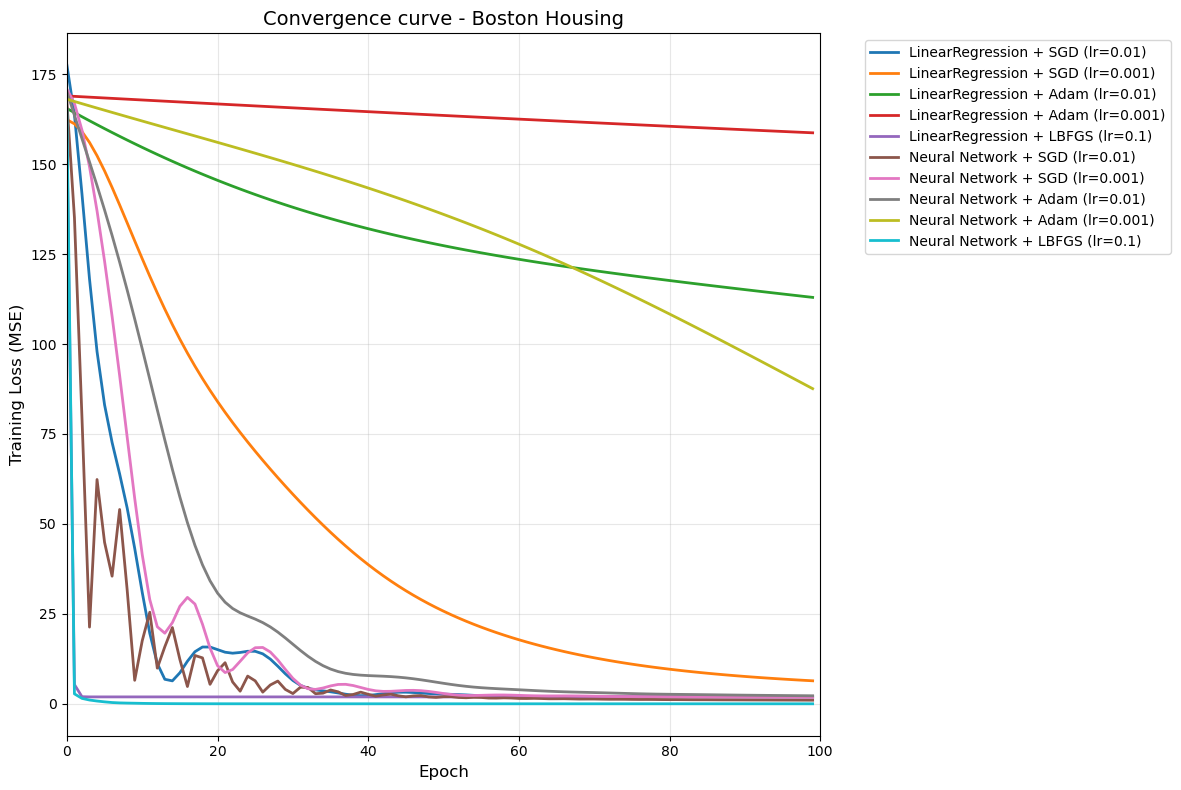

In [172]:
plt.figure(figsize=(12, 8))

# Linear Regression models
boston_lr_sgd_01 = LinearRegressionModel(input_dim_boston)
_, lr_sgd_train_01, _ = train_model(
    boston_lr_sgd_01, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.01, epochs=100, momentum=0.9
)

boston_lr_sgd_001 = LinearRegressionModel(input_dim_boston)
_, lr_sgd_train_001, _ = train_model(
    boston_lr_sgd_001, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.001, epochs=100, momentum=0.9
)

boston_lr_adam_01 = LinearRegressionModel(input_dim_boston)
_, lr_adam_train_01, _ = train_model(
    boston_lr_adam_01, optim.Adam, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.01, epochs=100
)

boston_lr_adam_001 = LinearRegressionModel(input_dim_boston)
_, lr_adam_train_001, _ = train_model(
    boston_lr_adam_001, optim.Adam, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.001, epochs=100
)

boston_lr_lbfgs = LinearRegressionModel(input_dim_boston)
_, lr_lbfgs_train, _ = train_lbfgs(
    boston_lr_lbfgs, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    epochs=100, lr=0.1
)

# Neural Network models
boston_nn_sgd_01 = SimpleNN(input_dim_boston)
_, nn_sgd_train_01, _ = train_model(
    boston_nn_sgd_01, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.01, epochs=100, momentum=0.9
)

boston_nn_sgd_001 = SimpleNN(input_dim_boston)
_, nn_sgd_train_001, _ = train_model(
    boston_nn_sgd_001, optim.SGD, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.001, epochs=100, momentum=0.9
)

boston_nn_adam_01 = SimpleNN(input_dim_boston)
_, nn_adam_train_01, _ = train_model(
    boston_nn_adam_01, optim.Adam, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.01, epochs=100
)

boston_nn_adam_001 = SimpleNN(input_dim_boston)
_, nn_adam_train_001, _ = train_model(
    boston_nn_adam_001, optim.Adam, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    lr=0.001, epochs=100
)

boston_nn_lbfgs = SimpleNN(input_dim_boston)
_, nn_lbfgs_train, _ = train_lbfgs(
    boston_nn_lbfgs, boston_X_train_t, boston_y_train_t, boston_X_test_t, boston_y_test_t,
    epochs=100, lr=0.1
)

# Plot convergence curves
plt.plot(lr_sgd_train_01, label='LinearRegression + SGD (lr=0.01)', linewidth=2)
plt.plot(lr_sgd_train_001, label='LinearRegression + SGD (lr=0.001)', linewidth=2)
plt.plot(lr_adam_train_01, label='LinearRegression + Adam (lr=0.01)', linewidth=2)
plt.plot(lr_adam_train_001, label='LinearRegression + Adam (lr=0.001)', linewidth=2)
plt.plot(lr_lbfgs_train, label='LinearRegression + LBFGS (lr=0.1)', linewidth=2)

plt.plot(nn_sgd_train_01, label='Neural Network + SGD (lr=0.01)', linewidth=2)
plt.plot(nn_sgd_train_001, label='Neural Network + SGD (lr=0.001)', linewidth=2)
plt.plot(nn_adam_train_01, label='Neural Network + Adam (lr=0.01)', linewidth=2)
plt.plot(nn_adam_train_001, label='Neural Network + Adam (lr=0.001)', linewidth=2)
plt.plot(nn_lbfgs_train, label='Neural Network + LBFGS (lr=0.1)', linewidth=2)

plt.title('Convergence curve - Boston Housing', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss (MSE)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(0, 100)

plt.tight_layout()
plt.show()

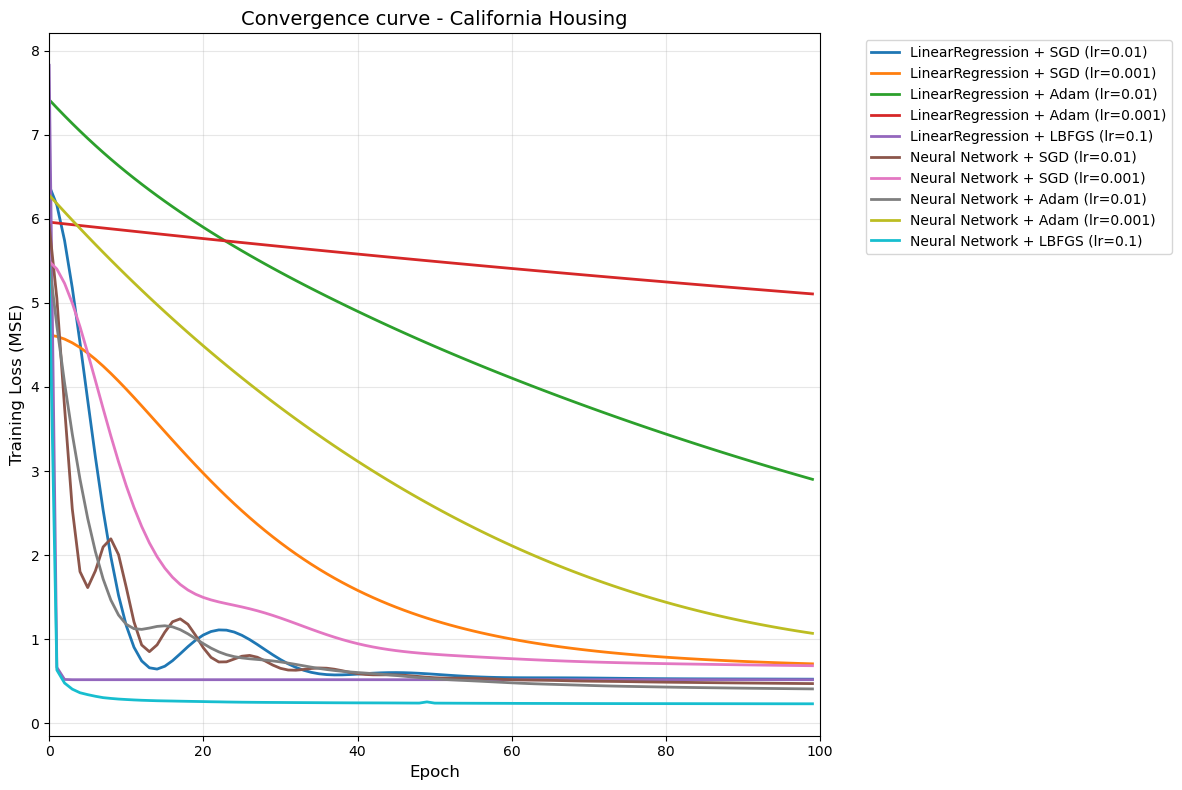

In [173]:
plt.figure(figsize=(12, 8))

# Linear Regression models
cal_lr_sgd_01 = LinearRegressionModel(input_dim_cal)
_, lr_sgd_train_01, _ = train_model(
    cal_lr_sgd_01, optim.SGD, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.01, epochs=100, momentum=0.9
)

cal_lr_sgd_001 = LinearRegressionModel(input_dim_cal)
_, lr_sgd_train_001, _ = train_model(
    cal_lr_sgd_001, optim.SGD, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.001, epochs=100, momentum=0.9
)

cal_lr_adam_01 = LinearRegressionModel(input_dim_cal)
_, lr_adam_train_01, _ = train_model(
    cal_lr_adam_01, optim.Adam, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.01, epochs=100
)

cal_lr_adam_001 = LinearRegressionModel(input_dim_cal)
_, lr_adam_train_001, _ = train_model(
    cal_lr_adam_001, optim.Adam, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.001, epochs=100
)

cal_lr_lbfgs = LinearRegressionModel(input_dim_cal)
_, lr_lbfgs_train, _ = train_lbfgs(
    cal_lr_lbfgs, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    epochs=100, lr=0.1
)

# Neural Network models
cal_nn_sgd_01 = SimpleNN(input_dim_cal)
_, nn_sgd_train_01, _ = train_model(
    cal_nn_sgd_01, optim.SGD, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.01, epochs=100, momentum=0.9
)

cal_nn_sgd_001 = SimpleNN(input_dim_cal)
_, nn_sgd_train_001, _ = train_model(
    cal_nn_sgd_001, optim.SGD, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.001, epochs=100, momentum=0.9
)

cal_nn_adam_01 = SimpleNN(input_dim_cal)
_, nn_adam_train_01, _ = train_model(
    cal_nn_adam_01, optim.Adam, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.01, epochs=100
)

cal_nn_adam_001 = SimpleNN(input_dim_cal)
_, nn_adam_train_001, _ = train_model(
    cal_nn_adam_001, optim.Adam, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    lr=0.001, epochs=100
)

cal_nn_lbfgs = SimpleNN(input_dim_cal)
_, nn_lbfgs_train, _ = train_lbfgs(
    cal_nn_lbfgs, cal_X_train_t, cal_y_train_t, cal_X_test_t, cal_y_test_t,
    epochs=100, lr=0.1
)

# Plot convergence curves
plt.plot(lr_sgd_train_01, label='LinearRegression + SGD (lr=0.01)', linewidth=2)
plt.plot(lr_sgd_train_001, label='LinearRegression + SGD (lr=0.001)', linewidth=2)
plt.plot(lr_adam_train_01, label='LinearRegression + Adam (lr=0.01)', linewidth=2)
plt.plot(lr_adam_train_001, label='LinearRegression + Adam (lr=0.001)', linewidth=2)
plt.plot(lr_lbfgs_train, label='LinearRegression + LBFGS (lr=0.1)', linewidth=2)

plt.plot(nn_sgd_train_01, label='Neural Network + SGD (lr=0.01)', linewidth=2)
plt.plot(nn_sgd_train_001, label='Neural Network + SGD (lr=0.001)', linewidth=2)
plt.plot(nn_adam_train_01, label='Neural Network + Adam (lr=0.01)', linewidth=2)
plt.plot(nn_adam_train_001, label='Neural Network + Adam (lr=0.001)', linewidth=2)
plt.plot(nn_lbfgs_train, label='Neural Network + LBFGS (lr=0.1)', linewidth=2)

plt.title('Convergence curve - California Housing', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss (MSE)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(0, 100)

plt.tight_layout()
plt.show()